# Exploratory data analysis on unlabeled data
We don't have labeled data yet, but we can still examine the data to see if there is something that stands out. 

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
logs_2018 = pd.read_csv('logs/logs_2018.csv', index_col='datetime', parse_dates=True)
logs_2018.head()

,source_ip,username,success,failure_reason
datetime,,,,
2018-01-01 00:00:54.641251,41.253.247.255,admin,True,NaN
2018-01-01 01:17:56.801849,230.71.97.153,zbrown,True,NaN
2018-01-01 02:48:52.437529,204.205.71.171,ckim,True,NaN
2018-01-01 03:32:15.644139,126.228.43.201,qjones,True,NaN
2018-01-01 03:50:42.710112,204.205.71.171,ckim,True,NaN


## EDA

In [3]:
logs_2018.dtypes

source_ip         object
username          object
success             bool
failure_reason    object
dtype: object

In [4]:
logs_2018.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48551 entries, 2018-01-01 00:00:54.641251 to 2018-12-31 23:53:21.101205
Data columns (total 4 columns):
source_ip         48551 non-null object
username          48551 non-null object
success           48551 non-null bool
failure_reason    28009 non-null object
dtypes: bool(1), object(3)
memory usage: 995.7+ KB


In [5]:
logs_2018.describe()

,source_ip,username,success,failure_reason
count,48551,48551,48551,28009
unique,9707,4196,2,3
top,132.124.26.73,kim,False,error_wrong_username
freq,306,388,28009,14475


### Distinct users per IP

In [6]:
logs_2018.groupby('source_ip').agg(
    dict(username='nunique')
).username.value_counts().describe()

count      35.000000
mean      277.342857
std      1436.042703
min         1.000000
25%         1.000000
50%         5.000000
75%        12.500000
max      8475.000000
Name: username, dtype: float64

### Calculate metrics per IP

In [7]:
pivot = pd.pivot_table(
    logs_2018, values='success', index=logs_2018.source_ip, 
    columns=logs_2018.failure_reason.fillna('success'), 
    aggfunc='count', fill_value=0
)
pivot.insert(0, 'attempts', pivot.sum(axis=1))
pivot = pivot.sort_values('attempts', ascending=False).assign(
    success_rate=lambda x: x.success / x.attempts,
    error_rate=lambda x: 1 - x.success_rate
)
pivot.head()

failure_reason,attempts,error_account_locked,error_wrong_password,error_wrong_username,success,success_rate,error_rate
source_ip,,,,,,,
132.124.26.73,306,15,60,48,183,0.598039,0.401961
16.118.156.50,288,25,51,54,158,0.548611,0.451389
82.151.213.13,285,17,57,49,162,0.568421,0.431579
208.101.11.88,285,11,54,52,168,0.589474,0.410526
204.205.71.171,281,18,59,43,161,0.572954,0.427046


### Visual Anomaly Detection

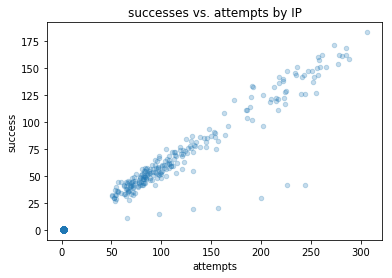

In [8]:
pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP', alpha=0.25
)

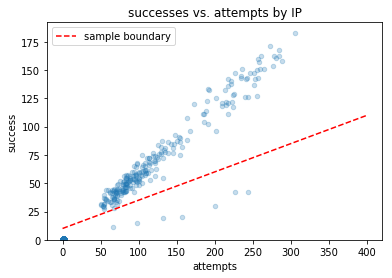

In [9]:
ax = pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP', alpha=0.25
)
x = np.linspace(0, 400)
ax.plot(x, .25*x + 10, 'r--', label='sample boundary')
plt.ylim(0, None)
plt.legend()

More IPs are hacker IPs because they get a new IP for each attack, while the valid users stick with the 1-3 they have. This makes the outliers on successes the valid users instead of the hackers.

attempts       AxesSubplot(0.125,0.125;0.352273x0.755)
success     AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

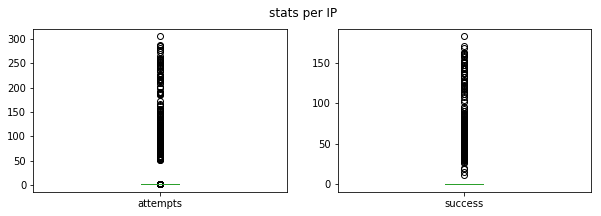

In [10]:
pivot[['attempts', 'success']].plot(
    kind='box', subplots=True, figsize=(10, 3),
    title='stats per IP'
)

Does looking at this on a minute resolution make anything stand out?

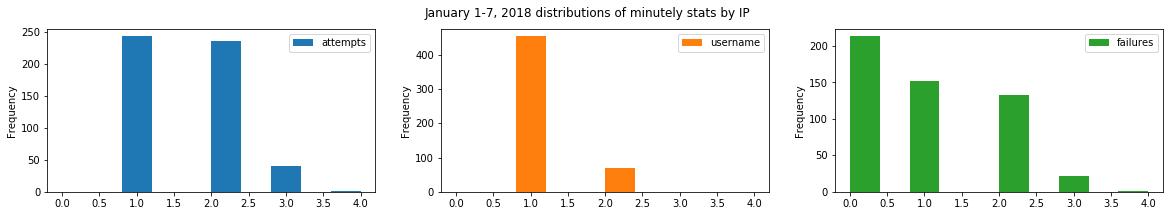

In [11]:
ax = logs_2018['2018-01-01':'2018-01-07'].assign(
    failures=lambda x: np.invert(x.success)
).groupby('source_ip').resample('1min').agg(
    {'username': 'nunique', 'success':'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures
).dropna().query('attempts > 0').reset_index().plot(
    y=['attempts', 'username', 'failures'], kind='hist',
    subplots=True, layout=(1, 3), figsize=(20, 3),
    title='January 1-7, 2018 distributions of minutely stats by IP'
)

There seems to be something with the number of usernames with failures per minute that we can use.

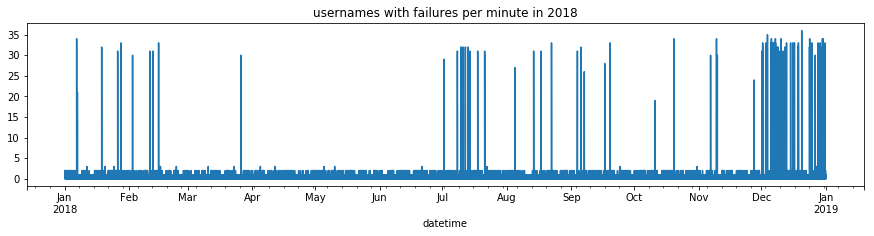

In [12]:
logs_2018['2018'].assign(
    failures=lambda x: np.invert(x.success)
).query('failures').resample('1min').agg(
    {'username':'nunique', 'failures': 'sum'}
).dropna().rename(
    columns={'username':'usernames_with_failures'}
).usernames_with_failures.plot(
    title='usernames with failures per minute in 2018',
    figsize=(15, 3)
)